In [1]:
import pandas as pd
import numpy as np
import seaborn
from matplotlib import pyplot, font_manager
from scipy.ndimage.filters import gaussian_filter1d

MI1C_1 = pd.read_json("../../Data/Stress/100VU/MI1C/10W-100VU-stress-c-report1.json")
MI1C_2 = pd.read_json("../../Data/Stress/100VU/MI1C/10W-100VU-stress-c-report2.json")
MI1C_3 = pd.read_json("../../Data/Stress/100VU/MI1C/10W-100VU-stress-c-report3.json")
MI1C_4 = pd.read_json("../../Data/Stress/100VU/MI1C/10W-100VU-stress-c-report4.json")
MI1C_5 = pd.read_json("../../Data/Stress/100VU/MI1C/10W-100VU-stress-c-report5.json")

MIC = [MI1C_1, MI1C_2, MI1C_3, MI1C_4, MI1C_5]
MIC = pd.concat(MIC, keys=[1, 2, 3, 4, 5])

unused_columns = [
    'timestamp', 'scenariosCreated', 'scenariosCompleted', 'scenarioDuration', 'scenarioCounts', 'codes', 'matches', 'customStats', 'pendingRequests'
]
    
MIC = MIC.drop(columns=unused_columns)

In [2]:
# Conver the timestamps to a time series with 10 seconds steps.
def get_time_series(dataframe: pd.DataFrame) -> pd.Series:
    number_of_rows = len(dataframe.index)

    return pd.Series(
        name='time',
        data=[element * 10 for element in range(number_of_rows)]
    )

time = get_time_series(MIC.loc[1])

In [3]:
# Create the latency dataframe.
def get_latency_metrics(time: pd.Series, dataframe: pd.DataFrame) -> pd.DataFrame: 
    #latencies = pd.DataFrame(data = [li for li in dataframe["latencies"]])
    #mean_latencies = pd.Series(name="mean", data = [(la.mean() / 1000000) for la in latencies.iloc])
    #, mean_latencies
    
    latency = pd.concat([time, dataframe['latency']], axis=1)
    latency = latency.set_index('time')
    
    for key, value in latency['latency'][0].items():
        latency[key] = latency['latency'].apply(lambda object: object[key])
  
    latency = latency.drop(columns=['latency', 'p99'])
    return latency[['max', 'p95', 'median', 'min']] 

In [9]:
def get_concurency(time: pd.Series, dataframe: pd.DataFrame) -> pd.DataFrame:
    concurency = pd.concat([time, dataframe['concurrency']], axis=1)
    concurency['concurrency'] = gaussian_filter1d(sigma=0.3, input=concurency['concurrency'])
    return concurency.set_index('time')

In [6]:
latency1 = get_latency_metrics(time, MIC.loc[1])
#latency2 = get_latency_metrics(time, MIC.loc[2])
#latency3 = get_latency_metrics(time, MIC.loc[3])
latency4 = get_latency_metrics(time, MIC.loc[4])
latency5 = get_latency_metrics(time, MIC.loc[5])

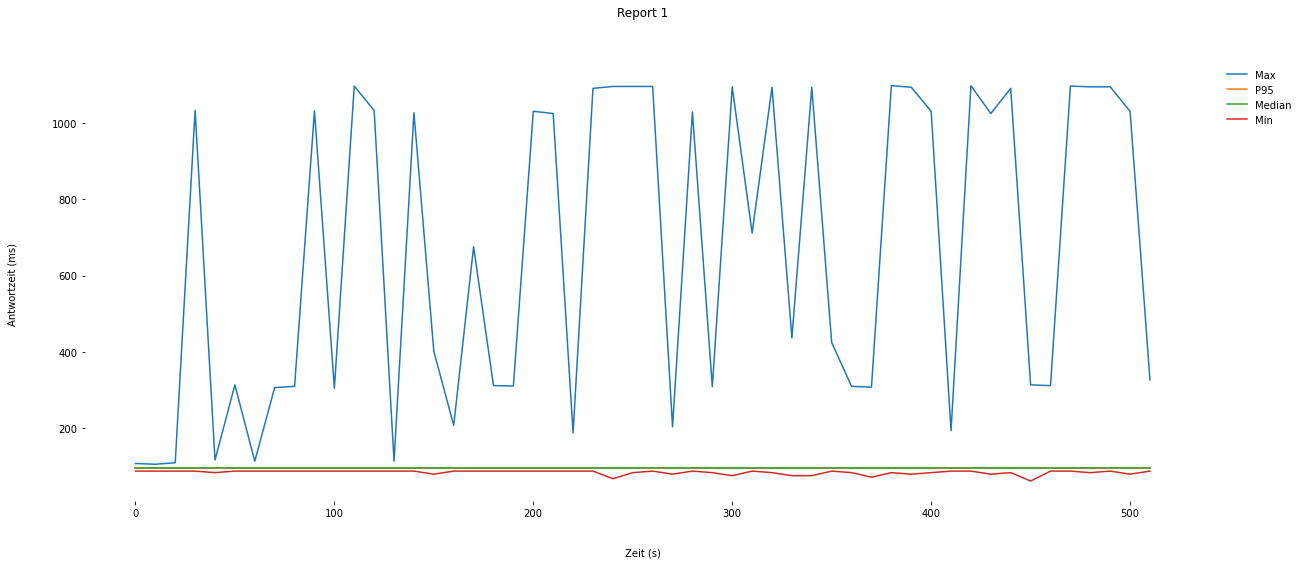

In [7]:
figure, row = pyplot.subplots(
    nrows=1,
    ncols=1,
    figsize=(20,8)
)

# Label settings

figure.subplots_adjust(wspace=0.08) # hspace=0

row.set_title('Report 1', y=1.1)

row.set_ylabel('Antwortzeit (ms)', labelpad=35)

row.set_xlabel('Zeit (s)', labelpad=30)

# Actual plot.

latency_plot = seaborn.lineplot(
    ax=row,
    dashes=False,
    legend=False,
    data=latency5,
)


# Grid settings.
seaborn.despine(
    left=True,
    bottom=True
)

# Legend settings.
latency_plot.legend(
    loc=2,
    frameon=False,
    framealpha=1.0,
    borderaxespad=0.0,
    bbox_to_anchor=(1.02, 1),
    labels=['Max', 'P95', 'Median', 'Min'],
)